# Comparison mass balance gradients of ML model, OGGM, PYGEM and GLOGEM

In [1]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from tqdm import tqdm
from itertools import product
import dill as pickle
import xarray as xr
import seaborn as sns
from scipy.stats import gaussian_kde
import os
import glob

import matplotlib.lines as mlines
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from helpers import get_ytrue_y_pred_agg
from helpers import get_ytrue_y_pred_agg_season
from helpers import get_prediction_per_season_test

from model_classes import CustomXGBRegressor

#from plotting_functions import plot_prediction_per_fold
from plotting_functions import plot_prediction
from plotting_functions import plot_gsearch_results
from plotting_functions import plot_prediction_per_season

Choose one glacier from each region \
Hansebreen, Tunsbergdalsbreen, Hellstugubreen and Langfjordjøkelen \
Compare mass balance gradient across models and add point observations where available


### Only Tunsbergdalsbreen

In [4]:
# Get file with glacier predictions
filepath = 'C:/Users/kasj/ML_MB_Norway/Data/glacier_predictions/with_predictions_2024-10-24_10-30-28/'
#filepath = 'C:/Users/kasj/ML_MB_Norway/Data/glacier_predictions/with_predictions_2024-10-25_09-45-30/'

filename = 'pred_00434.csv' # Tunsbergdalsbreen
#filename = 'pred_01258.csv' # Langfjordjøkelen
#filename = 'pred_00449.csv' # Helstugubreen

df_pred = pd.read_csv(filepath+filename)

In [6]:
import pandas as pd
import numpy as np

df = df_pred

# Step 1: Round the minimum and maximum altitude values to the nearest 10 meters
min_altitude_rounded = np.floor(df['altitude'].min() / 10) * 10
max_altitude_rounded = np.ceil(df['altitude'].max() / 10) * 10

# Step 2: Create bins with 10-meter intervals
bins = np.arange(min_altitude_rounded, max_altitude_rounded + 10, 10)

# Step 3: Assign altitude intervals to the bins
df['altitude_interval'] = pd.cut(df['altitude'], bins=bins, right=False)

# Step 4: Name each interval by the mean (i.e. every whole 5 meters)
bin_centers = {interval: round((interval.left + interval.right) / 2) for interval in df['altitude_interval'].cat.categories}
df['altitude_interval'] = df['altitude_interval'].apply(lambda x: bin_centers[x])

# Step 5: Group by 'year' and 'altitude_interval', and calculate the mean of 'Ba_pred'
mean_Ba_by_year_and_elevation = df.groupby(['year', 'altitude_interval'])['Ba_pred'].mean().reset_index()

print(mean_Ba_by_year_and_elevation)


      year altitude_interval    Ba_pred
0     1960               525 -11.618050
1     1960               535 -10.808599
2     1960               545 -10.627678
3     1960               555 -10.412354
4     1960               565 -10.618963
...    ...               ...        ...
8737  2021              1885   0.124495
8738  2021              1895   0.242813
8739  2021              1905   0.512126
8740  2021              1915   0.422956
8741  2021              1925   0.352293

[8742 rows x 3 columns]


C:\Users\kasj\AppData\Local\Temp\ipykernel_10912\1773052026.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


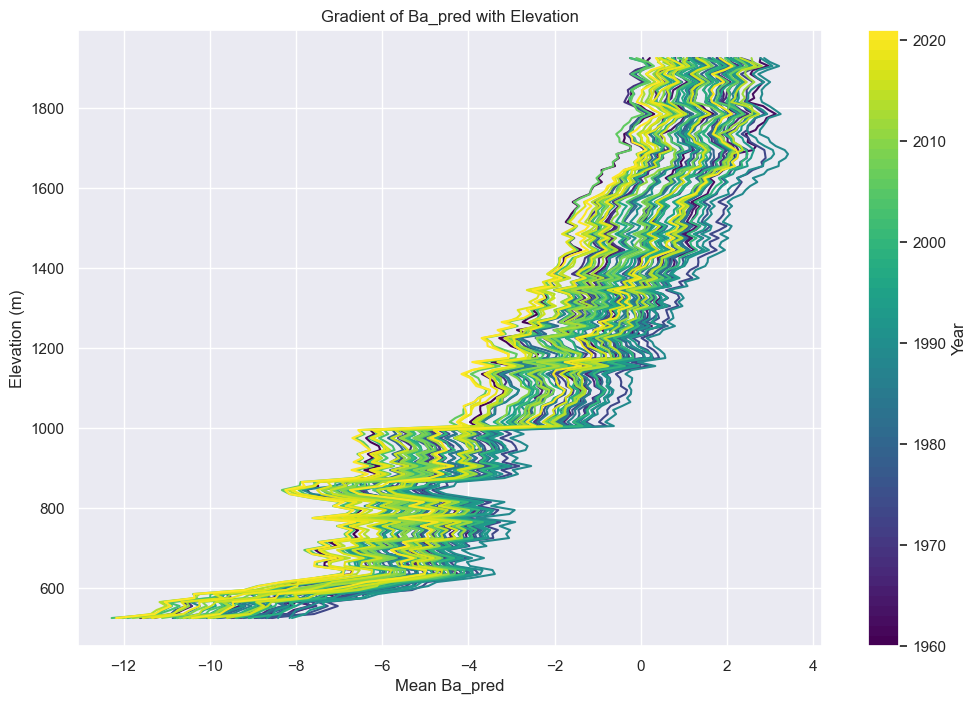

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure seaborn defaults are used for plots
#sns.set()

# Step 6: Plotting
plt.figure(figsize=(12, 8))

# Use the viridis colormap
cmap = plt.get_cmap("viridis", len(mean_Ba_by_year_and_elevation['year'].unique()))

# Plot each year with a different color
for i, (year, group) in enumerate(mean_Ba_by_year_and_elevation.groupby('year')):
    plt.plot(group['Ba_pred'], group['altitude_interval'], label=year, color=cmap(i))

# Add color bar to indicate the years
norm = plt.Normalize(mean_Ba_by_year_and_elevation['year'].min(), mean_Ba_by_year_and_elevation['year'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm)
cbar.set_label('Year')
plt.legend().remove()

# Labels and title
plt.xlabel('Mean Ba_pred')
plt.ylabel('Elevation (m)')
plt.title('Gradient of Ba_pred with Elevation')

# Show legend
#plt.legend(title='Year')

# Show plot
plt.show()


C:\Users\kasj\AppData\Local\Temp\ipykernel_10912\4214187128.py:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


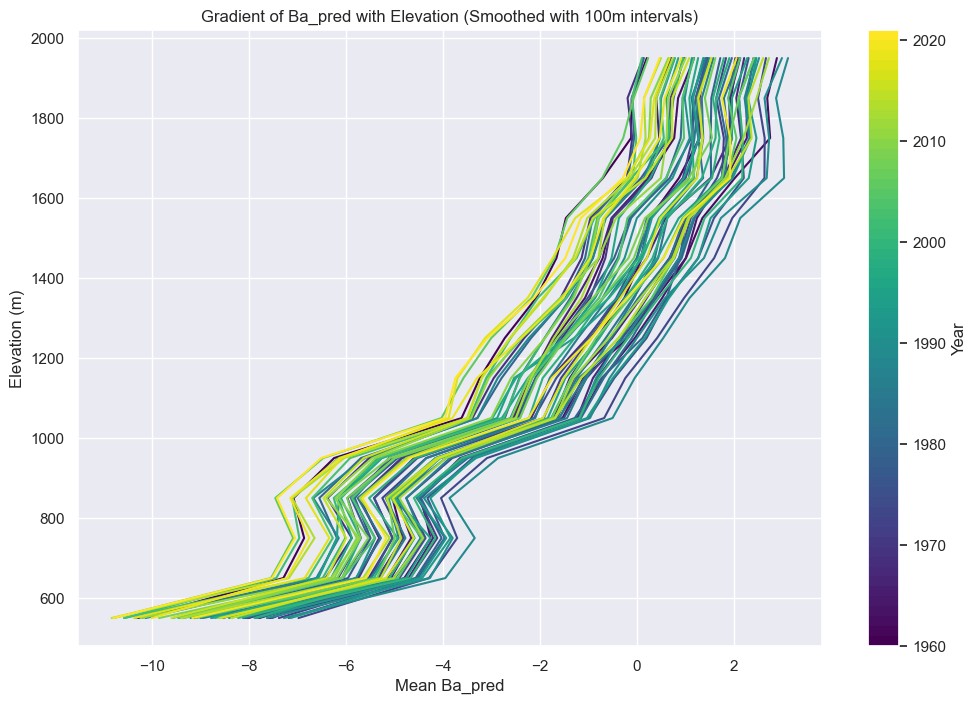

In [12]:

# Ensure seaborn defaults are used for plots
#sns.set()

df = df_pred.copy()

# Step 1: Round the minimum and maximum altitude values to the nearest 100 meters
min_altitude_rounded = np.floor(df['altitude'].min() / 100) * 100
max_altitude_rounded = np.ceil(df['altitude'].max() / 100) * 100

# Step 2: Create bins with 100-meter intervals
bins = np.arange(min_altitude_rounded, max_altitude_rounded + 100, 100)

# Step 3: Assign altitude intervals to the bins
df['altitude_interval'] = pd.cut(df['altitude'], bins=bins, right=False)

# Step 4: Name each interval by the mean (i.e. every whole 50 meters)
bin_centers = {interval: round((interval.left + interval.right) / 2) for interval in df['altitude_interval'].cat.categories}
df['altitude_interval'] = df['altitude_interval'].apply(lambda x: bin_centers[x])

# Step 5: Group by 'year' and 'altitude_interval', and calculate the mean of 'Ba_pred'
mean_Ba_by_year_and_elevation = df.groupby(['year', 'altitude_interval'])['Ba_pred'].mean().reset_index()

# Step 6: Plotting
plt.figure(figsize=(12, 8))

# Use the viridis colormap
cmap = plt.get_cmap("viridis", len(mean_Ba_by_year_and_elevation['year'].unique()))

# Plot each year with a different color
for i, (year, group) in enumerate(mean_Ba_by_year_and_elevation.groupby('year')):
    plt.plot(group['Ba_pred'], group['altitude_interval'], label=year, color=cmap(i))

# Add color bar to indicate the years
norm = plt.Normalize(mean_Ba_by_year_and_elevation['year'].min(), mean_Ba_by_year_and_elevation['year'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm)
cbar.set_label('Year')
plt.legend().remove()

# Labels and title
plt.xlabel('Mean Ba_pred')
plt.ylabel('Elevation (m)')
plt.title('Gradient of Ba_pred with Elevation (Smoothed with 100m intervals)')

# Show legend
#plt.legend(title='Year')

# Show plot
plt.show()


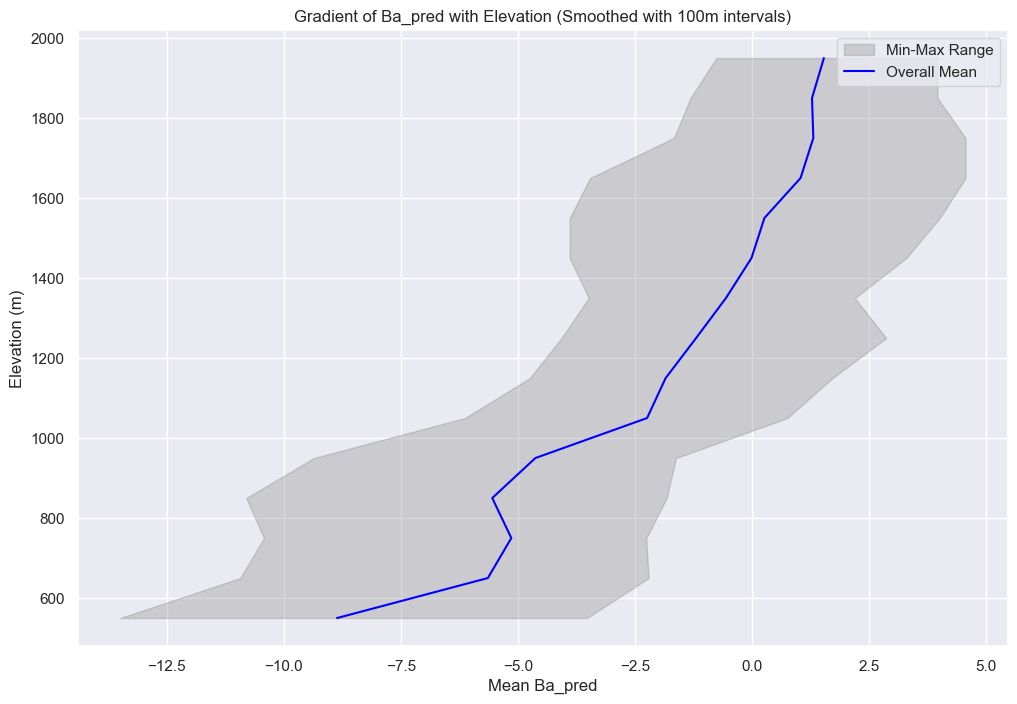

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure seaborn defaults are used for plots
#sns.set()

df=df_pred.copy()

# Step 1: Round the minimum and maximum altitude values to the nearest 100 meters
min_altitude_rounded = np.floor(df['altitude'].min() / 100) * 100
max_altitude_rounded = np.ceil(df['altitude'].max() / 100) * 100

# Step 2: Create bins with 100-meter intervals
bins = np.arange(min_altitude_rounded, max_altitude_rounded + 100, 100)

# Step 3: Assign altitude intervals to the bins
df['altitude_interval'] = pd.cut(df['altitude'], bins=bins, right=False)

# Step 4: Name each interval by the mean (i.e. every whole 50 meters)
bin_centers = {interval: round((interval.left + interval.right) / 2) for interval in df['altitude_interval'].cat.categories}
df['altitude_interval'] = df['altitude_interval'].apply(lambda x: bin_centers[x])

# Step 5: Group by 'altitude_interval' and calculate the mean, min, and max of 'Ba_pred'
agg_Ba_by_elevation = df.groupby('altitude_interval').agg(
    mean_Ba=('Ba_pred', 'mean'),
    min_Ba=('Ba_pred', 'min'),
    max_Ba=('Ba_pred', 'max')
).reset_index()

# Step 6: Plotting
plt.figure(figsize=(12, 8))

# Plot shaded area between min and max Ba_pred
plt.fill_betweenx(agg_Ba_by_elevation['altitude_interval'],
                  agg_Ba_by_elevation['min_Ba'], agg_Ba_by_elevation['max_Ba'],
                  color='gray', alpha=0.3, label='Min-Max Range')

# Plot mean gradient over all years
plt.plot(agg_Ba_by_elevation['mean_Ba'], agg_Ba_by_elevation['altitude_interval'],
         label='Overall Mean', color='blue')

# Labels and title
plt.xlabel('Mean Ba_pred')
plt.ylabel('Elevation (m)')
plt.title('Gradient of Ba_pred with Elevation (Smoothed with 100m intervals)')
plt.legend()

# Show plot
plt.show()




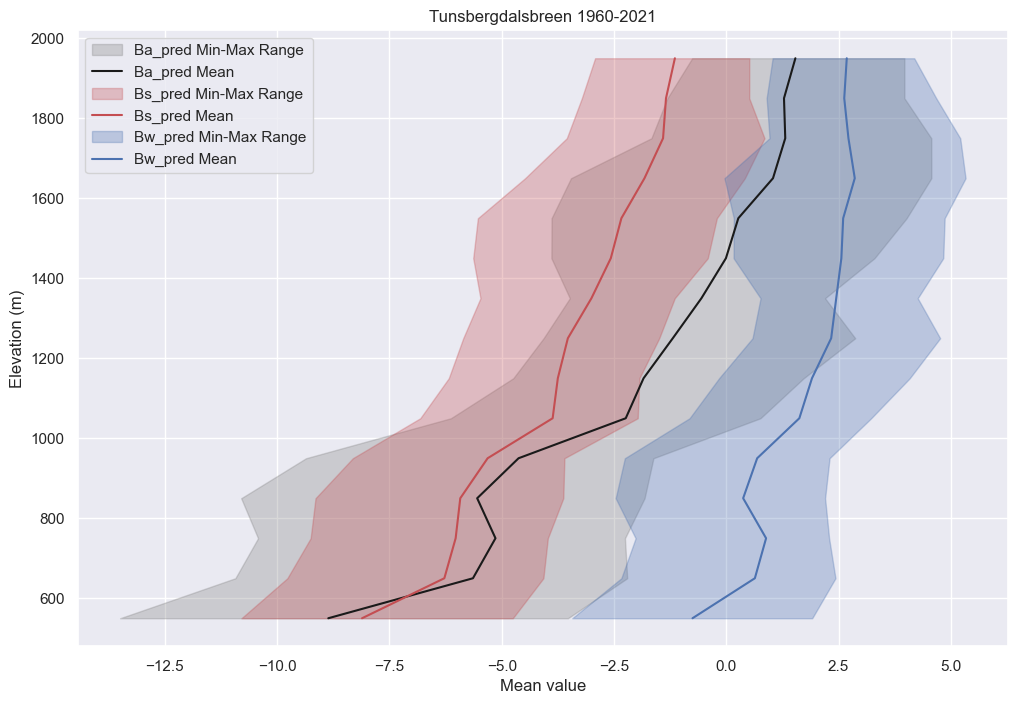

In [19]:

# Ensure seaborn defaults are used for plots
#sns.set()

df = df_pred.copy()

# Step 1: Round the minimum and maximum altitude values to the nearest 100 meters
min_altitude_rounded = np.floor(df['altitude'].min() / 100) * 100
max_altitude_rounded = np.ceil(df['altitude'].max() / 100) * 100

# Step 2: Create bins with 100-meter intervals
bins = np.arange(min_altitude_rounded, max_altitude_rounded + 100, 100)

# Step 3: Assign altitude intervals to the bins
df['altitude_interval'] = pd.cut(df['altitude'], bins=bins, right=False)

# Step 4: Name each interval by the mean (i.e., every whole 50 meters)
bin_centers = {interval: round((interval.left + interval.right) / 2) for interval in df['altitude_interval'].cat.categories}
df['altitude_interval'] = df['altitude_interval'].apply(lambda x: bin_centers[x])

# Step 5: Group by 'altitude_interval' and calculate the mean, min, and max of 'Ba_pred', 'Bs_pred', and 'Bw_pred'
agg_Ba_by_elevation = df.groupby('altitude_interval').agg(
    mean_Ba=('Ba_pred', 'mean'),
    min_Ba=('Ba_pred', 'min'),
    max_Ba=('Ba_pred', 'max')
).reset_index()

agg_Bs_by_elevation = df.groupby('altitude_interval').agg(
    mean_Bs=('Bs_pred', 'mean'),
    min_Bs=('Bs_pred', 'min'),
    max_Bs=('Bs_pred', 'max')
).reset_index()

agg_Bw_by_elevation = df.groupby('altitude_interval').agg(
    mean_Bw=('Bw_pred', 'mean'),
    min_Bw=('Bw_pred', 'min'),
    max_Bw=('Bw_pred', 'max')
).reset_index()

# Step 6: Plotting
plt.figure(figsize=(12, 8))

# Plot shaded area and mean line for Ba_pred
plt.fill_betweenx(agg_Ba_by_elevation['altitude_interval'],
                  agg_Ba_by_elevation['min_Ba'], agg_Ba_by_elevation['max_Ba'],
                  color='gray', alpha=0.3, label='Ba_pred Min-Max Range')
plt.plot(agg_Ba_by_elevation['mean_Ba'], agg_Ba_by_elevation['altitude_interval'],
         label='Ba_pred Mean', color='k')

# Plot shaded area and mean line for Bs_pred
plt.fill_betweenx(agg_Bs_by_elevation['altitude_interval'],
                  agg_Bs_by_elevation['min_Bs'], agg_Bs_by_elevation['max_Bs'],
                  color='C3', alpha=0.3, label='Bs_pred Min-Max Range')
plt.plot(agg_Bs_by_elevation['mean_Bs'], agg_Bs_by_elevation['altitude_interval'],
         label='Bs_pred Mean', color='C3')

# Plot shaded area and mean line for Bw_pred
plt.fill_betweenx(agg_Bw_by_elevation['altitude_interval'],
                  agg_Bw_by_elevation['min_Bw'], agg_Bw_by_elevation['max_Bw'],
                  color='C0', alpha=0.3, label='Bw_pred Min-Max Range')
plt.plot(agg_Bw_by_elevation['mean_Bw'], agg_Bw_by_elevation['altitude_interval'],
         label='Bw_pred Mean', color='C0')

# Labels and title
plt.xlabel('Mass balance (m w.e.)')
plt.ylabel('Elevation (m)')
# Add title here: RGI60-08.XXXXX where XXXXX is the numbers from the filename.

plt.legend()

# Show plot
plt.show()


### All test glaciers, whole period

In [ ]:
#filename = 'pred_00434.csv' # Tunsbergdalsbreen
#filename = 'pred_01258.csv' # Langfjordjøkelen
#filename = 'pred_00449.csv' # Helstugubreen
#filename = 'pred_02650 # Ålfotbreen
# 02916 Bondhusbreen
# 01598 Svartisheibreen
# 02384 Rundvassbreen (blåmannsisen)

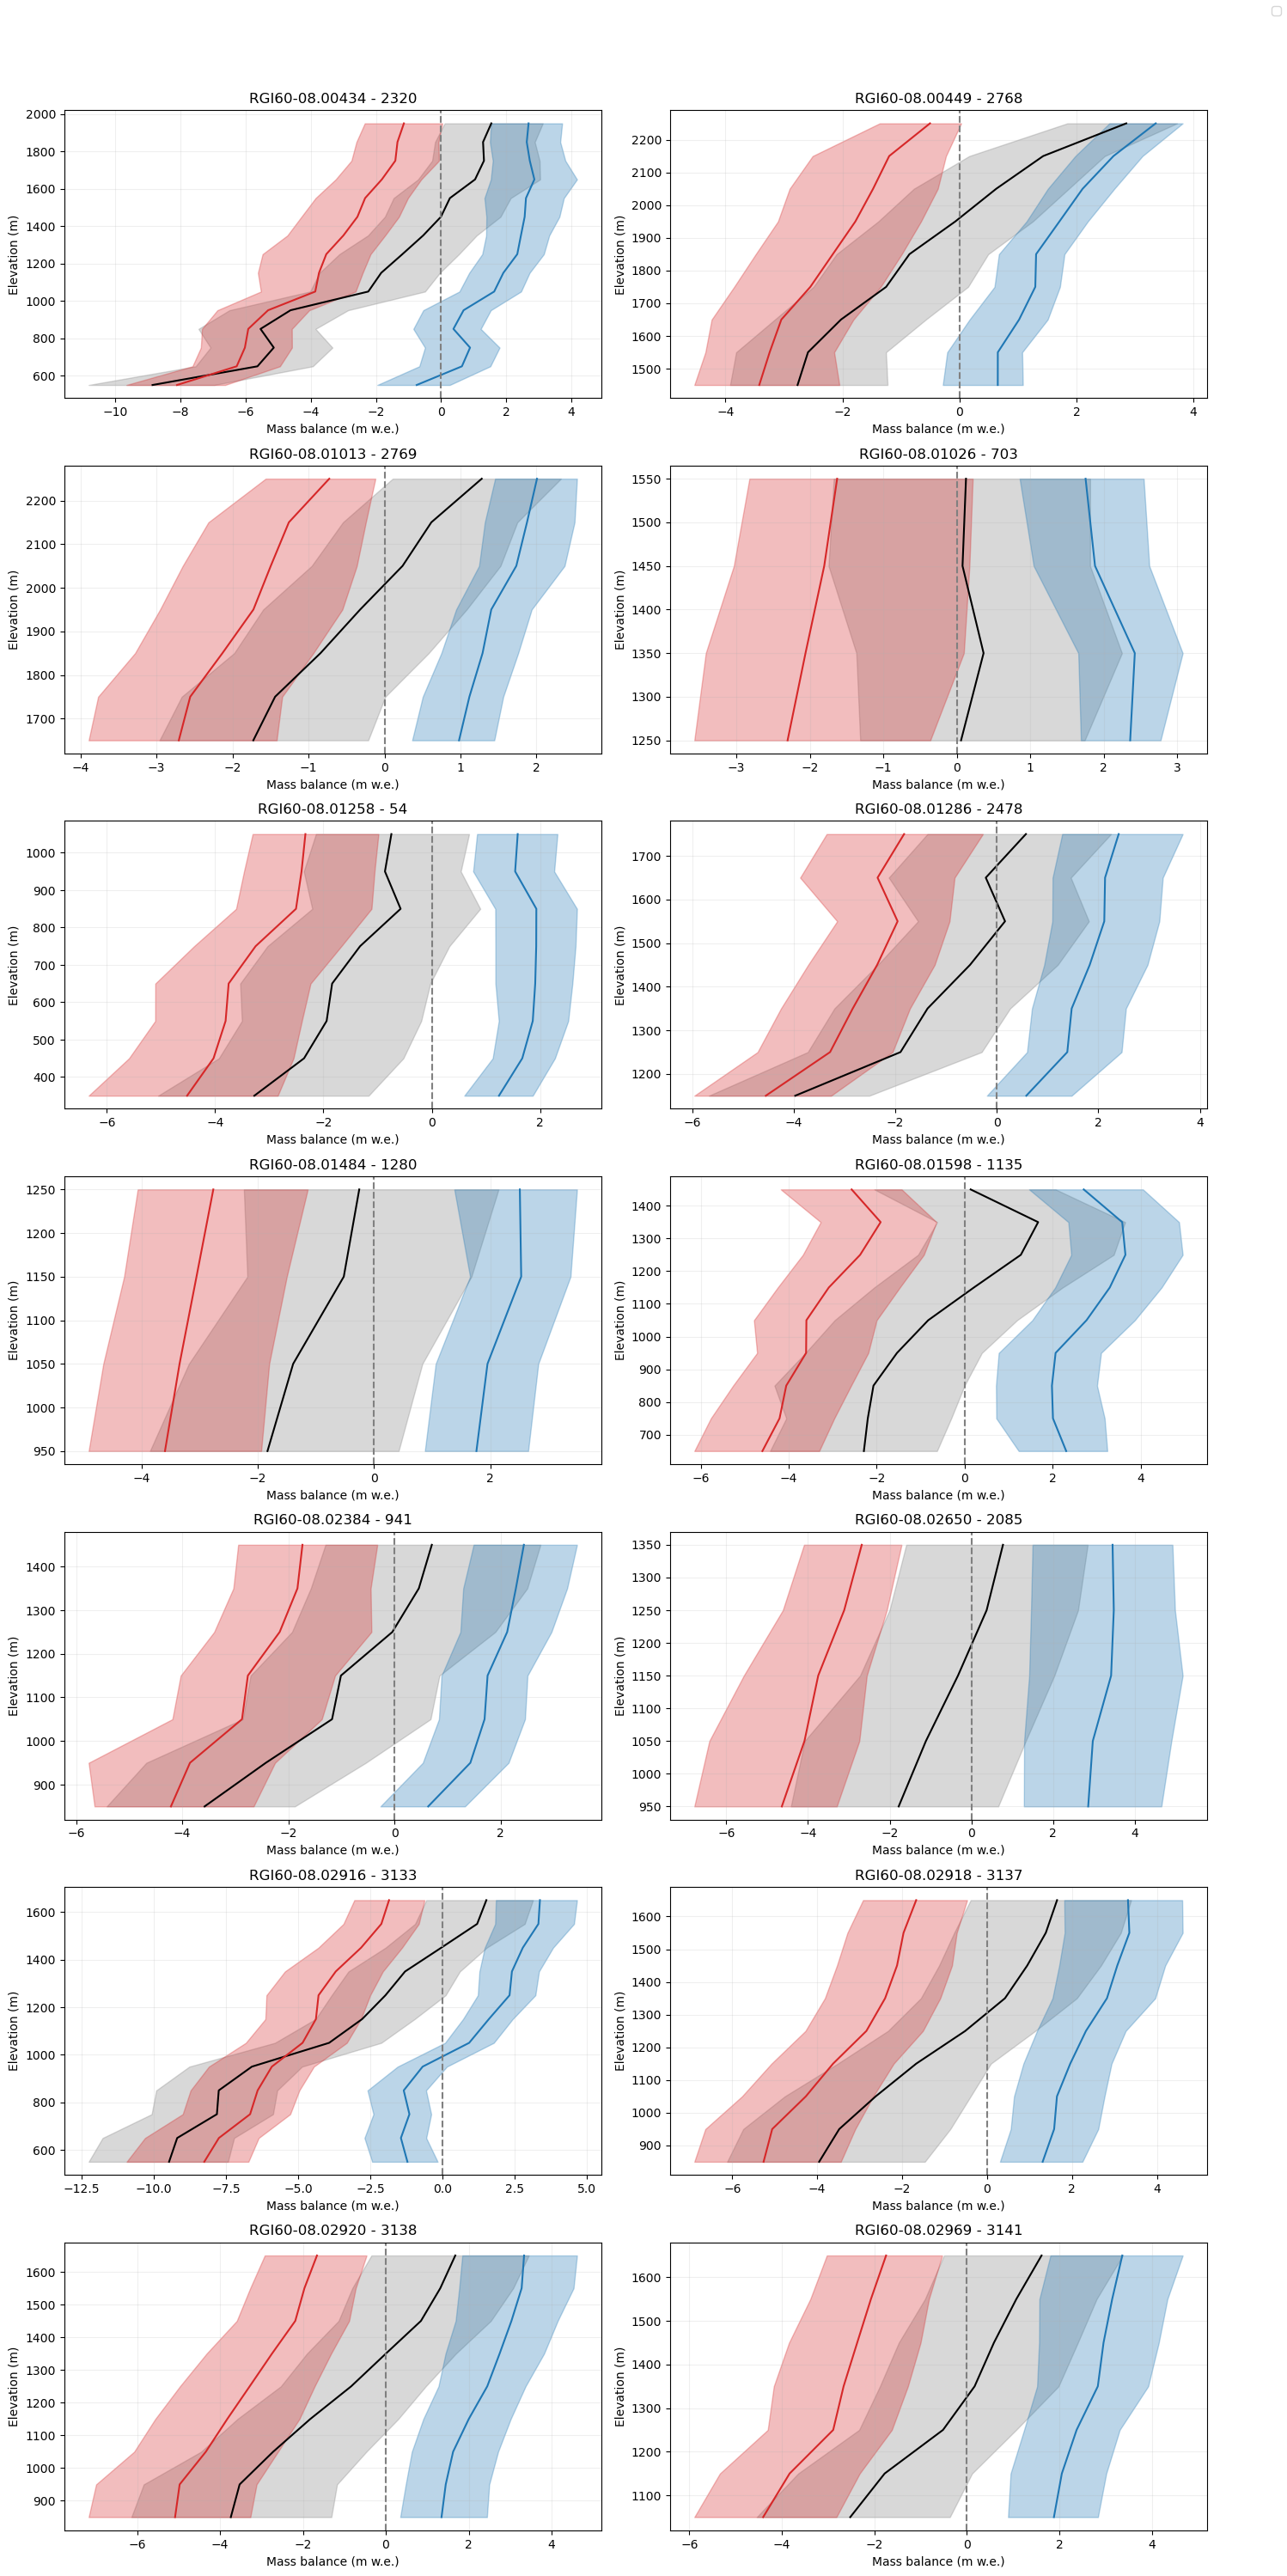

In [2]:
# Ensure seaborn defaults are used for plots
#sns.set()

# Path to the folder containing the CSV files
folder_path = 'C:/Users/kasj/ML_MB_Norway/Data/glacier_predictions/with_predictions_2024-10-24_10-30-28/'

# List of test glaciers to include
test_glaciers = ['00434', '00449', '01013', '01026', '01258', '01286', '01484', '01598', '02384', '02650', '02916', '02918', '02920', '02969']

# Get a list of all CSV files in the folder
file_list = glob.glob(os.path.join(folder_path, '*.csv'))

# Filter the file_list to include only the files with the IDs in test_glaciers
filtered_file_list = [filename for filename in file_list if any(glacier_id in filename for glacier_id in test_glaciers)]

# Number of rows and columns for the subplots
nrows = 7
ncols = 2

# Create a figure with the specified number of subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 30))
axes = axes.flatten()

for idx, filename in enumerate(filtered_file_list):
    if idx >= nrows * ncols:
        break  # Stop if we have more files than subplots

    # Read each CSV file into a DataFrame
    df_pred = pd.read_csv(filename)
    
    # Ensure the DataFrame contains the necessary columns
    required_columns = ['altitude', 'Ba_pred', 'Bs_pred', 'Bw_pred', 'year']
    if not all(column in df_pred.columns for column in required_columns):
        print(f"Skipping {filename} as it does not contain the required columns.")
        continue

    # Step 1: Round the minimum and maximum altitude values to the nearest 100 meters
    min_altitude_rounded = np.floor(df_pred['altitude'].min() / 100) * 100
    max_altitude_rounded = np.ceil(df_pred['altitude'].max() / 100) * 100

    # Step 2: Create bins with 100-meter intervals
    bins = np.arange(min_altitude_rounded, max_altitude_rounded + 100, 100)

    # Step 3: Assign altitude intervals to the bins
    df_pred['altitude_interval'] = pd.cut(df_pred['altitude'], bins=bins, right=False)

    # Step 4: Name each interval by the mean (i.e., every whole 50 meters)
    bin_centers = {interval: round((interval.left + interval.right) / 2) for interval in df_pred['altitude_interval'].cat.categories}
    df_pred['altitude_interval'] = df_pred['altitude_interval'].apply(lambda x: bin_centers[x])

    # Step 5: Group by 'altitude_interval' and 'year' to calculate the mean values per year
    yearly_Ba_by_elevation = df_pred.groupby(['altitude_interval', 'year']).Ba_pred.mean().reset_index()
    yearly_Bs_by_elevation = df_pred.groupby(['altitude_interval', 'year']).Bs_pred.mean().reset_index()
    yearly_Bw_by_elevation = df_pred.groupby(['altitude_interval', 'year']).Bw_pred.mean().reset_index()

    # Step 6: Now calculate the mean, min, and max of these yearly means for each altitude interval
    agg_Ba_by_elevation = yearly_Ba_by_elevation.groupby('altitude_interval').agg(
        mean_Ba=('Ba_pred', 'mean'),
        min_Ba=('Ba_pred', 'min'),
        max_Ba=('Ba_pred', 'max')
    ).reset_index()

    agg_Bs_by_elevation = yearly_Bs_by_elevation.groupby('altitude_interval').agg(
        mean_Bs=('Bs_pred', 'mean'),
        min_Bs=('Bs_pred', 'min'),
        max_Bs=('Bs_pred', 'max')
    ).reset_index()

    agg_Bw_by_elevation = yearly_Bw_by_elevation.groupby('altitude_interval').agg(
        mean_Bw=('Bw_pred', 'mean'),
        min_Bw=('Bw_pred', 'min'),
        max_Bw=('Bw_pred', 'max')
    ).reset_index()

    # Get the subplot axis
    ax = axes[idx]

    # Step 7: Plotting
    # Plot shaded area and mean line for Ba_pred
    ax.fill_betweenx(agg_Ba_by_elevation['altitude_interval'],
                     agg_Ba_by_elevation['min_Ba'], agg_Ba_by_elevation['max_Ba'],
                     color='gray', alpha=0.3, label='Ba_pred Min-Max Range' if idx == 0 else "")
    ax.plot(agg_Ba_by_elevation['mean_Ba'], agg_Ba_by_elevation['altitude_interval'],
            label='Ba_pred Mean' if idx == 0 else "", color='k')

    # Plot shaded area and mean line for Bs_pred
    ax.fill_betweenx(agg_Bs_by_elevation['altitude_interval'],
                     agg_Bs_by_elevation['min_Bs'], agg_Bs_by_elevation['max_Bs'],
                     color='C3', alpha=0.3, label='Bs_pred Min-Max Range' if idx == 0 else "")
    ax.plot(agg_Bs_by_elevation['mean_Bs'], agg_Bs_by_elevation['altitude_interval'],
            label='Bs_pred Mean' if idx == 0 else "", color='C3')

    # Plot shaded area and mean line for Bw_pred
    ax.fill_betweenx(agg_Bw_by_elevation['altitude_interval'],
                     agg_Bw_by_elevation['min_Bw'], agg_Bw_by_elevation['max_Bw'],
                     color='C0', alpha=0.3, label='Bw_pred Min-Max Range' if idx == 0 else "")
    ax.plot(agg_Bw_by_elevation['mean_Bw'], agg_Bw_by_elevation['altitude_interval'],
            label='Bw_pred Mean' if idx == 0 else "", color='C0')

    glacier_name = df_pred['BREID'].iloc[0]

    ax.axvline(x=0, color='grey', linestyle='--')
    # Labels and title for this subplot
    ax.set_xlabel('Mass balance (m w.e.)')
    ax.set_ylabel('Elevation (m)')
    #ax.set_title(f"RGI60-08.{os.path.basename(filename).split('_')[1].split('.')[0]}")
    ax.set_title(f"RGI60-08.{os.path.basename(filename).split('_')[1].split('.')[0]} - {glacier_name}")
    ax.grid(alpha=0.2)
# Ensure legends show up
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

# Adjust the layout
plt.tight_layout(rect=[0, 0, 0.95, 0.97])
plt.show()


## Add other models

In [3]:
# Get mass balance predictions for OGGM, PYGEM, GLOGEM
filepath_models = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/'

fn_glogem_ann_seas_elev_band = 'GloGEM_annual_seasonal_mb_elev_band.nc'
fn_oggm_ann_seas_elev_band = 'OGGM_annual_seasonal_mb_elev_band.nc'
fn_pygem_ann_seas_elev_band = 'PyGEM_annual_seasonal_mb_elev_band.nc'

with xr.open_dataset(filepath_models + fn_glogem_ann_seas_elev_band) as ds_glogem:
    ds_glogem_ann_seas_elev_band = ds_glogem

with xr.open_dataset(filepath_models + fn_oggm_ann_seas_elev_band) as ds_oggm:
    ds_oggm_ann_seas_elev_band = ds_oggm

with xr.open_dataset(filepath_models + fn_pygem_ann_seas_elev_band) as ds_pygem:
    ds_pygem_ann_seas_elev_band = ds_pygem

In [4]:
ds_pygem_ann_seas_elev_band

<xarray.Dataset>
Dimensions:    (elevation: 226, time: 62, ID: 32)
Coordinates:
  * elevation  (elevation) float64 85.0 95.0 105.0 ... 2.325e+03 2.335e+03
  * time       (time) datetime64[ns] 1961-10-01 1962-10-01 ... 2022-10-01
  * ID         (ID) object '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
Data variables:
    mb_annual  (ID, time, elevation) float64 ...
    mb_winter  (ID, time, elevation) float64 ...
    mb_summer  (ID, time, elevation) float64 ...
Attributes:
    Model:    PyGEM

In [69]:
# List of test glaciers to include (formatted to match the dataset)
test_glaciers = ['0434', '0449', '1013', '1026', '1258', '1286', '1484', '1598', '2384', '2650', '2916', '2918', '2920', '2969']

# Filter the dataset to include only the IDs in test_glaciers
ds_glogem_cropped = ds_glogem_ann_seas_elev_band.sel(ID=test_glaciers)
ds_oggm_cropped = ds_oggm_ann_seas_elev_band.sel(ID=test_glaciers)
ds_pygem_cropped = ds_pygem_ann_seas_elev_band.sel(ID=test_glaciers)

start_time = '1979-10-01'
end_time = '2019-09-30'

# Select the time slice from the dataset
ds_glogem_cropped = ds_glogem_cropped.sel(time=slice(start_time, end_time))
ds_oggm_cropped = ds_oggm_cropped.sel(time=slice(start_time, end_time))
ds_pygem_cropped = ds_pygem_cropped.sel(time=slice(start_time, end_time))

ds_glogem_mean = ds_glogem_cropped.mean(dim='time')
ds_oggm_mean = ds_oggm_cropped.mean(dim='time')
ds_pygem_mean = ds_pygem_cropped.mean(dim='time')
ds_pygem_mean['elevation']=ds_pygem_mean['elevation'].astype(int)


In [70]:
ds_pygem_mean

<xarray.Dataset>
Dimensions:    (elevation: 226, ID: 14)
Coordinates:
  * elevation  (elevation) int32 85 95 105 115 125 ... 2295 2305 2315 2325 2335
  * ID         (ID) object '0434' '0449' '1013' '1026' ... '2918' '2920' '2969'
Data variables:
    mb_annual  (ID, elevation) float64 nan nan nan nan nan ... nan nan nan nan
    mb_winter  (ID, elevation) float64 nan nan nan nan nan ... nan nan nan nan
    mb_summer  (ID, elevation) float64 nan nan nan nan nan ... nan nan nan nan

In [81]:

# Define the elevation bins (100m intervals)
elevation_bins = np.arange(0, 2400 + 100, 100)
bin_labels = (elevation_bins[:-1] + elevation_bins[1:]) / 2

# Convert the dataset to a Pandas DataFrame
df_glogem = ds_glogem_mean.to_dataframe().reset_index()
df_oggm = ds_oggm_mean.to_dataframe().reset_index()
df_pygem = ds_pygem_mean.to_dataframe().reset_index()

# Assign elevation intervals to the elevation bins
df_glogem['elevation_bins'] = pd.cut(df_glogem['elevation'], bins=elevation_bins, labels=bin_labels, right=False)
df_oggm['elevation_bins'] = pd.cut(df_oggm['elevation'], bins=elevation_bins, labels=bin_labels, right=False)
df_pygem['elevation_bins'] = pd.cut(df_pygem['elevation'], bins=elevation_bins, labels=bin_labels, right=False)

# Group by 'ID' and 'elevation_bins', and compute the mean
df_glogem_mean = df_glogem.groupby(['ID', 'elevation_bins']).mean().reset_index()
df_oggm_mean = df_oggm.groupby(['ID', 'elevation_bins']).mean().reset_index()
df_pygem_mean = df_pygem.groupby(['ID', 'elevation_bins']).mean().reset_index()



In [72]:
df_oggm

,elevation,ID,mb_annual,mb_winter,mb_summer,elevation_bins
0,85,0434,NaN,NaN,NaN,50.0
1,85,0449,NaN,NaN,NaN,50.0
2,85,1013,NaN,NaN,NaN,50.0
3,85,1026,NaN,NaN,NaN,50.0
4,85,1258,NaN,NaN,NaN,50.0
...,...,...,...,...,...,...
3159,2335,2650,NaN,NaN,NaN,2350.0
3160,2335,2916,NaN,NaN,NaN,2350.0
3161,2335,2918,NaN,NaN,NaN,2350.0
3162,2335,2920,NaN,NaN,NaN,2350.0


In [132]:
# Add point mass balances
# Specify filepaths and filenames.          
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename_obs = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate_svf.csv'

# Load data.
df_obs = pd.read_csv(filepath + filename_obs)

#df_obs = df_obs[df_obs['balance_winter'] != 9.99].reset_index(drop=True)
df_obs = df_obs.drop([3358,3359]).reset_index(drop=True)



C:\Users\kasj\AppData\Local\Temp\ipykernel_9824\4093486634.py:13: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_obs = pd.read_csv(filepath + filename_obs)


In [133]:
df_obs[df_obs['balance_winter'] == 9.99]

,RGIID,GLIMSID,BREID,utm_zone,utm_east_approx,utm_north_approx,altitude_approx,location_description,location_id,stake_no,...,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate,skyview_factor


In [134]:
df_obs

,RGIID,GLIMSID,BREID,utm_zone,utm_east_approx,utm_north_approx,altitude_approx,location_description,location_id,stake_no,...,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate,skyview_factor
0,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1012,...,0.005116,0.002688,0.002334,0.001159,0.003054,0.003977,0.004691,0.001449,341.227919,0.778997
1,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.001831,0.004597,0.005634,0.002244,0.003412,0.000891,0.002129,0.004860,341.227919,0.798494
2,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.004949,0.003286,0.003739,0.004709,0.005111,0.001253,0.002506,0.003256,341.227919,0.803510
3,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.002495,0.002263,0.001256,0.002129,0.003969,0.003559,0.002119,0.002851,341.227919,0.803510
4,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1016,...,0.003314,0.004417,0.002704,0.003991,0.001780,0.004257,0.005193,0.000710,341.227919,0.817480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4164,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1509,...,0.011964,0.007288,0.003555,0.005019,0.004730,0.007226,0.005739,0.011397,917.419759,0.932281
4165,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1509,...,0.002572,0.000807,0.009360,0.006135,0.006760,0.005158,0.008218,0.005461,917.419759,0.932281
4166,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1514,...,0.008543,0.010311,0.006261,0.008175,0.005974,0.006563,0.008015,0.003896,917.419759,0.932281
4167,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1514,...,0.008916,0.003751,0.004573,0.004449,0.005235,0.008926,0.011151,0.009556,917.419759,0.932281


In [135]:
df_obs['elevation_bins'] = pd.cut(df_obs['altitude'], bins=elevation_bins, labels=bin_labels, right=False)
df_obs['year']=pd.to_datetime(df_obs['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
df_obs['year'] = df_obs.year.dt.year.astype('Int64')

In [136]:
df_obs

,RGIID,GLIMSID,BREID,utm_zone,utm_east_approx,utm_north_approx,altitude_approx,location_description,location_id,stake_no,...,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate,skyview_factor,elevation_bins,year
0,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1012,...,0.002334,0.001159,0.003054,0.003977,0.004691,0.001449,341.227919,0.778997,450.0,2013
1,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.005634,0.002244,0.003412,0.000891,0.002129,0.004860,341.227919,0.798494,450.0,2014
2,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.003739,0.004709,0.005111,0.001253,0.002506,0.003256,341.227919,0.803510,450.0,2015
3,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.001256,0.002129,0.003969,0.003559,0.002119,0.002851,341.227919,0.803510,450.0,2016
4,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1016,...,0.002704,0.003991,0.001780,0.004257,0.005193,0.000710,341.227919,0.817480,450.0,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4164,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1509,...,0.003555,0.005019,0.004730,0.007226,0.005739,0.011397,917.419759,0.932281,1050.0,2012
4165,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1509,...,0.009360,0.006135,0.006760,0.005158,0.008218,0.005461,917.419759,0.932281,1050.0,2013
4166,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1514,...,0.006261,0.008175,0.005974,0.006563,0.008015,0.003896,917.419759,0.932281,1050.0,2015
4167,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1514,...,0.004573,0.004449,0.005235,0.008926,0.011151,0.009556,917.419759,0.932281,1050.0,2016


In [137]:
df_obs = df_obs[(df_obs['year']>=1980) & (df_obs['year']<=2019)]


In [138]:
df_obs

,RGIID,GLIMSID,BREID,utm_zone,utm_east_approx,utm_north_approx,altitude_approx,location_description,location_id,stake_no,...,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate,skyview_factor,elevation_bins,year
0,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1012,...,0.002334,0.001159,0.003054,0.003977,0.004691,0.001449,341.227919,0.778997,450.0,2013
1,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.005634,0.002244,0.003412,0.000891,0.002129,0.004860,341.227919,0.798494,450.0,2014
2,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.003739,0.004709,0.005111,0.001253,0.002506,0.003256,341.227919,0.803510,450.0,2015
3,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.001256,0.002129,0.003969,0.003559,0.002119,0.002851,341.227919,0.803510,450.0,2016
4,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1016,...,0.002704,0.003991,0.001780,0.004257,0.005193,0.000710,341.227919,0.817480,450.0,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4164,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1509,...,0.003555,0.005019,0.004730,0.007226,0.005739,0.011397,917.419759,0.932281,1050.0,2012
4165,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1509,...,0.009360,0.006135,0.006760,0.005158,0.008218,0.005461,917.419759,0.932281,1050.0,2013
4166,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1514,...,0.006261,0.008175,0.005974,0.006563,0.008015,0.003896,917.419759,0.932281,1050.0,2015
4167,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1514,...,0.004573,0.004449,0.005235,0.008926,0.011151,0.009556,917.419759,0.932281,1050.0,2016


In [124]:

df_obs_mean = df_obs.groupby(['BREID','elevation_bins']).mean().reset_index()
df_obs_max = df_obs.groupby(['BREID','elevation_bins']).max().reset_index()
df_obs_min = df_obs.groupby(['BREID','elevation_bins']).min().reset_index()

# Merge the min and max values with the mean values
df_obs_mean['min_annual'] = df_obs_min['balance_netto']  
df_obs_mean['max_annual'] = df_obs_max['balance_netto']
df_obs_mean['min_winter'] = df_obs_min['balance_winter']  
df_obs_mean['max_winter'] = df_obs_max['balance_winter']
df_obs_mean['min_summer'] = df_obs_min['balance_summer']  
df_obs_mean['max_summer'] = df_obs_max['balance_summer']

C:\Users\kasj\AppData\Local\Temp\ipykernel_9824\2234562070.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_obs_mean = df_obs.groupby(['BREID','elevation_bins']).mean().reset_index()
C:\Users\kasj\AppData\Local\Temp\ipykernel_9824\2234562070.py:3: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  df_obs_max = df_obs.groupby(['BREID','elevation_bins']).max().reset_index()
C:\Users\kasj\AppData\Local\Temp\ipykernel_9824\2234562070.py:4: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the fu

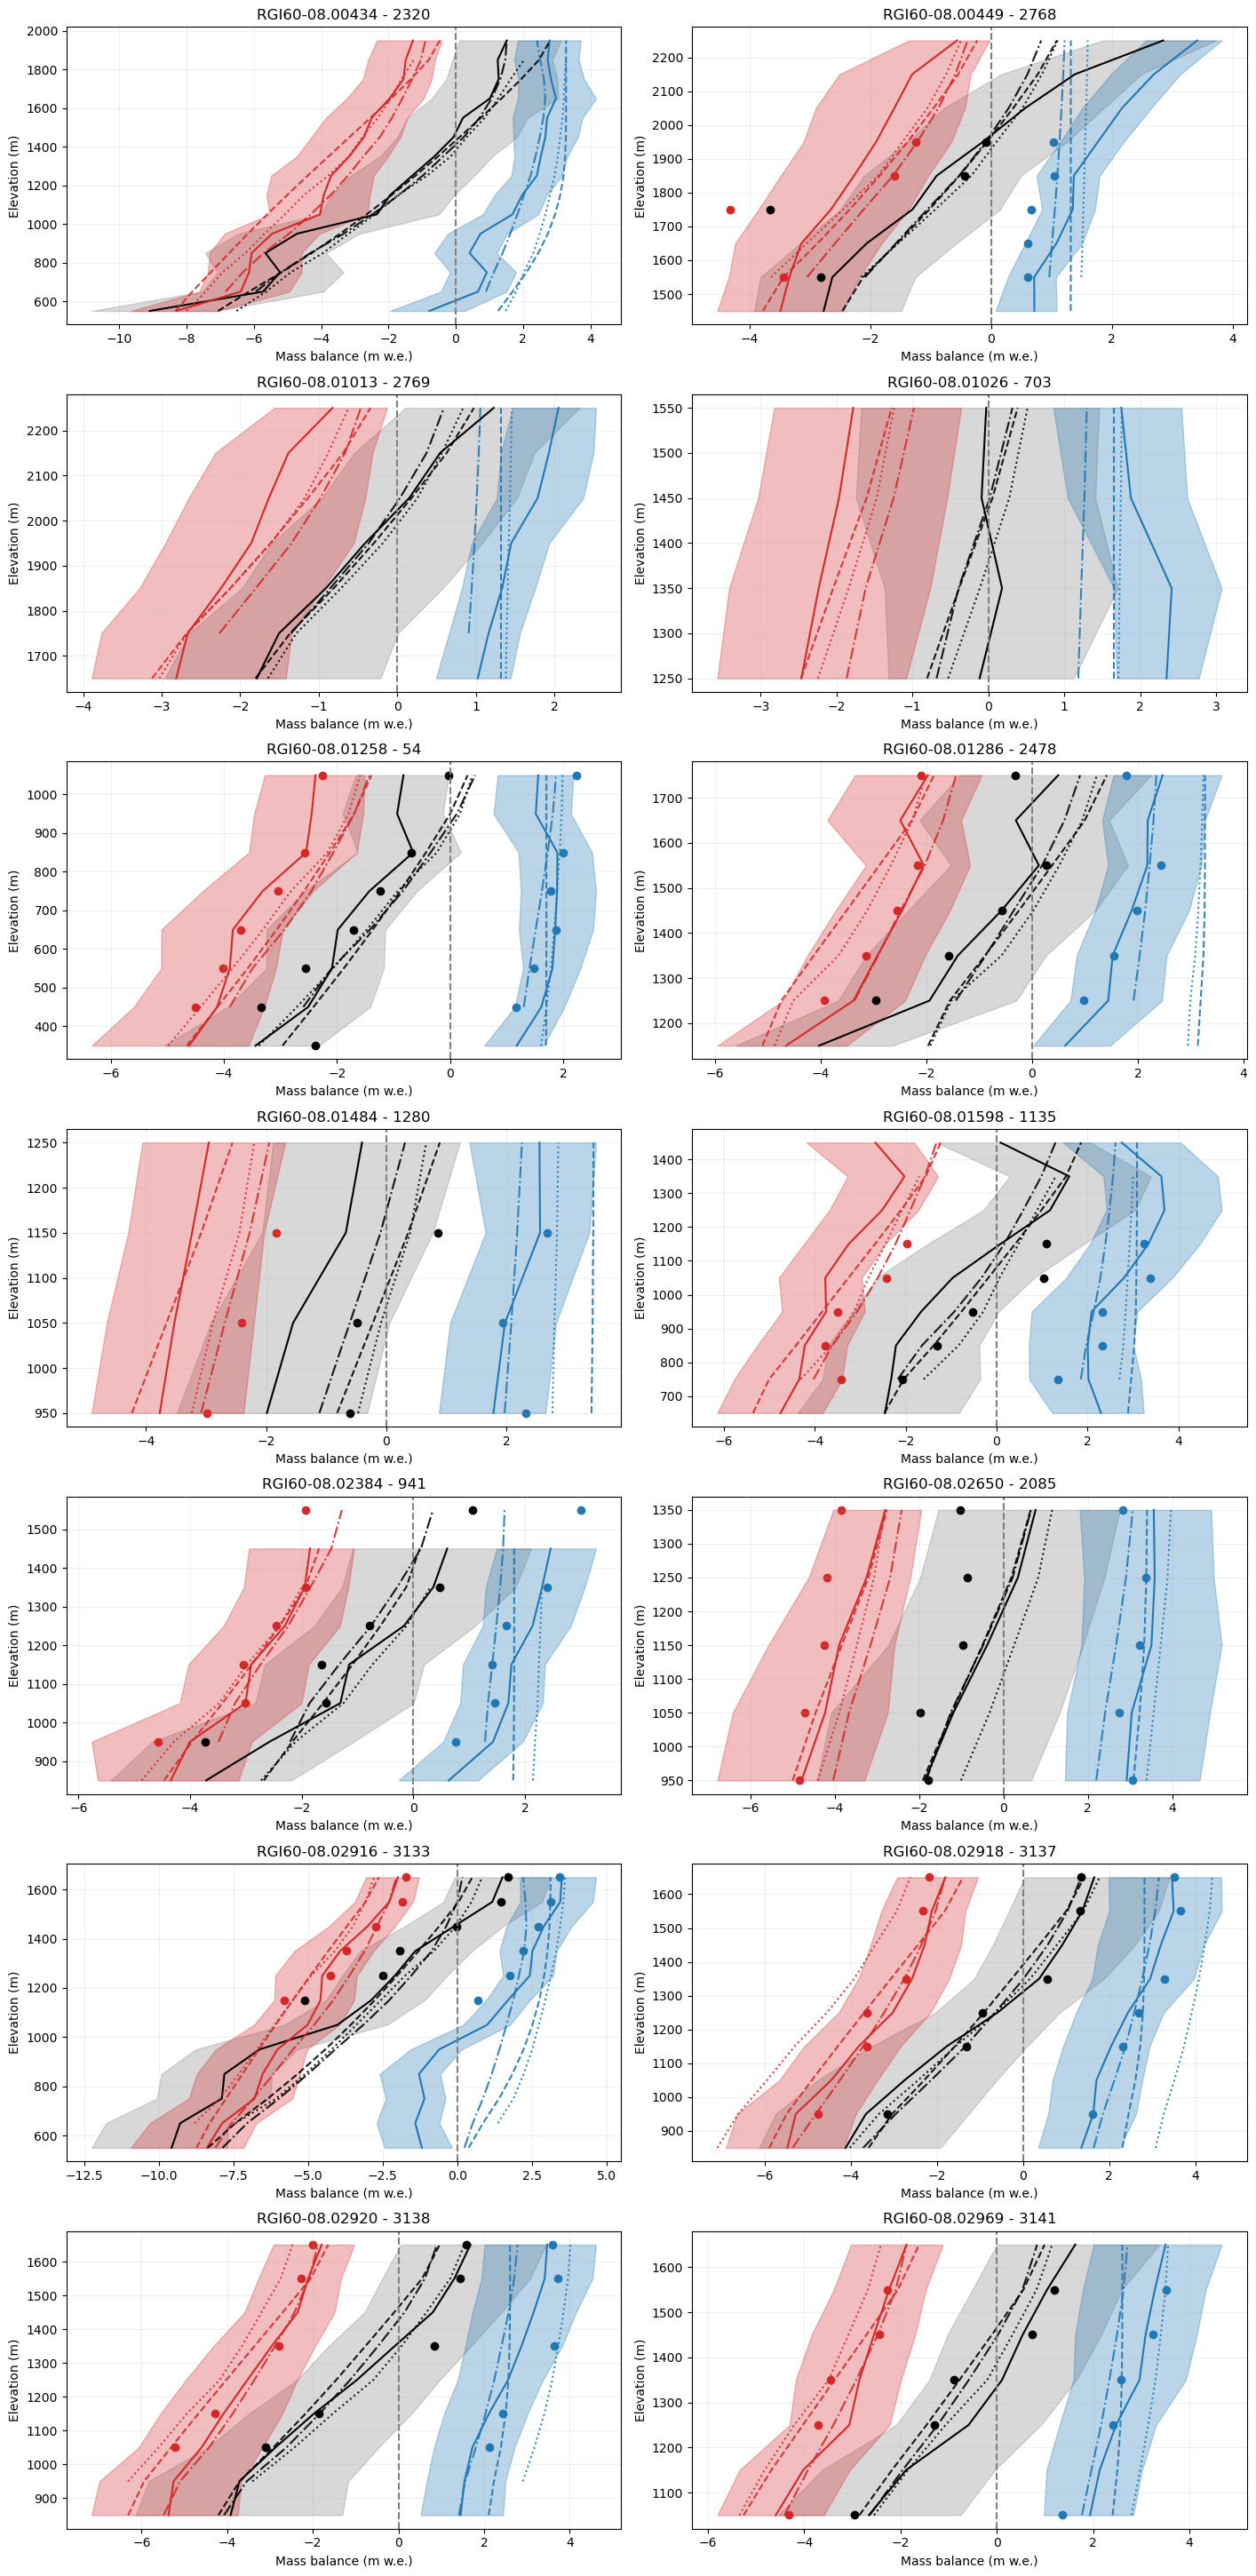

In [127]:
# Ensure seaborn defaults are used for plots
#sns.set()
start_year = 1980
end_year = 2019

# Path to the folder containing the CSV files
folder_path = 'C:/Users/kasj/ML_MB_Norway/Data/glacier_predictions/with_predictions_2024-10-24_10-30-28/'

# List of test glaciers to include
test_glaciers = ['00434', '00449', '01013', '01026', '01258', '01286', '01484', '01598', '02384', '02650', '02916', '02918', '02920', '02969']

# Get a list of all CSV files in the folder
file_list = glob.glob(os.path.join(folder_path, '*.csv'))

# Filter the file_list to include only the files with the IDs in test_glaciers
filtered_file_list = [filename for filename in file_list if any(glacier_id in filename for glacier_id in test_glaciers)]

# Number of rows and columns for the subplots
nrows = 7
ncols = 2

cm=1/2.54
fontsize=7

# Create a figure with the specified number of subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 30))
axes = axes.flatten()

for idx, filename in enumerate(filtered_file_list):
    if idx >= nrows * ncols:
        break  # Stop if we have more files than subplots

    # Read each CSV file into a DataFrame
    df_pred = pd.read_csv(filename)
    df_pred = df_pred[(df_pred['year']>=start_year) & (df_pred['year']<=end_year)]
    
    # Ensure the DataFrame contains the necessary columns
    required_columns = ['altitude', 'Ba_pred', 'Bs_pred', 'Bw_pred', 'year']
    if not all(column in df_pred.columns for column in required_columns):
        print(f"Skipping {filename} as it does not contain the required columns.")
        continue

    # Step 1: Round the minimum and maximum altitude values to the nearest 100 meters
    min_altitude_rounded = np.floor(df_pred['altitude'].min() / 100) * 100
    max_altitude_rounded = np.ceil(df_pred['altitude'].max() / 100) * 100

    # Step 2: Create bins with 100-meter intervals
    bins = np.arange(min_altitude_rounded, max_altitude_rounded + 100, 100)

    # Step 3: Assign altitude intervals to the bins
    df_pred['altitude_interval'] = pd.cut(df_pred['altitude'], bins=bins, right=False)

    # Step 4: Name each interval by the mean (i.e., every whole 50 meters)
    bin_centers = {interval: round((interval.left + interval.right) / 2) for interval in df_pred['altitude_interval'].cat.categories}
    df_pred['altitude_interval'] = df_pred['altitude_interval'].apply(lambda x: bin_centers[x])

    # Step 5: Group by 'altitude_interval' and 'year' to calculate the mean values per year
    yearly_Ba_by_elevation = df_pred.groupby(['altitude_interval', 'year']).Ba_pred.mean().reset_index()
    yearly_Bs_by_elevation = df_pred.groupby(['altitude_interval', 'year']).Bs_pred.mean().reset_index()
    yearly_Bw_by_elevation = df_pred.groupby(['altitude_interval', 'year']).Bw_pred.mean().reset_index()

    # Step 6: Now calculate the mean, min, and max of these yearly means for each altitude interval
    agg_Ba_by_elevation = yearly_Ba_by_elevation.groupby('altitude_interval').agg(
        mean_Ba=('Ba_pred', 'mean'),
        min_Ba=('Ba_pred', 'min'),
        max_Ba=('Ba_pred', 'max')
    ).reset_index()

    agg_Bs_by_elevation = yearly_Bs_by_elevation.groupby('altitude_interval').agg(
        mean_Bs=('Bs_pred', 'mean'),
        min_Bs=('Bs_pred', 'min'),
        max_Bs=('Bs_pred', 'max')
    ).reset_index()

    agg_Bw_by_elevation = yearly_Bw_by_elevation.groupby('altitude_interval').agg(
        mean_Bw=('Bw_pred', 'mean'),
        min_Bw=('Bw_pred', 'min'),
        max_Bw=('Bw_pred', 'max')
    ).reset_index()

    # Get the subplot axis
    ax = axes[idx]

    # Step 7: Plotting
    # Plot shaded area and mean line for Ba_pred
    ax.fill_betweenx(agg_Ba_by_elevation['altitude_interval'],
                     agg_Ba_by_elevation['min_Ba'], agg_Ba_by_elevation['max_Ba'],
                     color='gray', alpha=0.3, label='Ba_pred Min-Max Range' if idx == 0 else "")
    ax.plot(agg_Ba_by_elevation['mean_Ba'], agg_Ba_by_elevation['altitude_interval'],
            label='Ba_pred Mean' if idx == 0 else "", color='k')

    # Plot shaded area and mean line for Bs_pred
    ax.fill_betweenx(agg_Bs_by_elevation['altitude_interval'],
                     agg_Bs_by_elevation['min_Bs'], agg_Bs_by_elevation['max_Bs'],
                     color='C3', alpha=0.3, label='Bs_pred Min-Max Range' if idx == 0 else "")
    ax.plot(agg_Bs_by_elevation['mean_Bs'], agg_Bs_by_elevation['altitude_interval'],
            label='Bs_pred Mean' if idx == 0 else "", color='C3')

    # Plot shaded area and mean line for Bw_pred
    ax.fill_betweenx(agg_Bw_by_elevation['altitude_interval'],
                     agg_Bw_by_elevation['min_Bw'], agg_Bw_by_elevation['max_Bw'],
                     color='C0', alpha=0.3, label='Bw_pred Min-Max Range' if idx == 0 else "")
    ax.plot(agg_Bw_by_elevation['mean_Bw'], agg_Bw_by_elevation['altitude_interval'],
            label='Bw_pred Mean' if idx == 0 else "", color='C0')

    glacier_id = df_pred['RGIID'].iloc[0][-4:]

    glacier_df_glogem = df_glogem_mean[df_glogem_mean['ID'] == glacier_id]
    glacier_df_oggm = df_oggm_mean[df_oggm_mean['ID'] == glacier_id]
    glacier_df_pygem = df_pygem_mean[df_pygem_mean['ID'] == glacier_id]

    # Plot the mean mass balance values
    # Diamond/dashdot for GloGEM
    # Square/dashed for OGGM
    # Circle/dotted for PyGEM
    alpha=0.9
    ax.plot(glacier_df_glogem['mb_annual'], glacier_df_glogem['elevation_bins'].astype(float), label='Annual Mass Balance', linestyle='-.',color='k', alpha=alpha)#marker='D', 
    ax.plot(glacier_df_glogem['mb_winter'], glacier_df_glogem['elevation_bins'].astype(float), label='Winter Mass Balance', linestyle='-.', color='C0',alpha=alpha)
    ax.plot(glacier_df_glogem['mb_summer'], glacier_df_glogem['elevation_bins'].astype(float), label='Summer Mass Balance', linestyle='-.', color='C3',alpha=alpha)
    ax.plot(glacier_df_oggm['mb_annual'], glacier_df_oggm['elevation_bins'].astype(float), label='Annual Mass Balance', linestyle='--', color='k',alpha=alpha)
    ax.plot(glacier_df_oggm['mb_winter'], glacier_df_oggm['elevation_bins'].astype(float), label='Winter Mass Balance', linestyle='--', color='C0',alpha=alpha)
    ax.plot(glacier_df_oggm['mb_summer'], glacier_df_oggm['elevation_bins'].astype(float), label='Summer Mass Balance', linestyle='--', color='C3',alpha=alpha)
    ax.plot(glacier_df_pygem['mb_annual'], glacier_df_pygem['elevation_bins'].astype(float), label='Annual Mass Balance', linestyle=':', color='k',alpha=alpha)
    ax.plot(glacier_df_pygem['mb_winter'], glacier_df_pygem['elevation_bins'].astype(float), label='Winter Mass Balance', linestyle=':', color='C0',alpha=alpha)
    ax.plot(glacier_df_pygem['mb_summer'], glacier_df_pygem['elevation_bins'].astype(float), label='Summer Mass Balance', linestyle=':', color='C3',alpha=alpha)
           
    glacier_name = df_pred['BREID'].iloc[0]

    # Add point mass balance observations
    glacier_obs = df_obs_mean[df_obs_mean['BREID']==glacier_name]
    ax.scatter(glacier_obs['balance_netto'], glacier_obs['elevation_bins'], marker='o', color='k')
    ax.scatter(glacier_obs['balance_winter'], glacier_obs['elevation_bins'], marker='o', color='C0')
    ax.scatter(glacier_obs['balance_summer'], glacier_obs['elevation_bins'], marker='o', color='C3')

    #ann_err = [glacier_obs['balance_netto'] - glacier_obs['min_annual'], glacier_obs['max_annual'] - glacier_obs['balance_netto']]
    #ax.errorbar(glacier_obs['balance_netto'], glacier_obs['elevation_bins'], xerr=ann_err, fmt='.', lw=2, capsize=3, alpha=0.7, zorder=0)
    
    ax.axvline(x=0, color='grey', linestyle='--')
    # Labels and title for this subplot
    ax.set_xlabel('Mass balance (m w.e.)', fontsize=fontsize)
    ax.set_ylabel('Elevation (m)',fontsize=fontsize)
    
    #ax.set_title(f"RGI60-08.{os.path.basename(filename).split('_')[1].split('.')[0]}")
    ax.set_title(f"RGI60-08.{os.path.basename(filename).split('_')[1].split('.')[0]} - {glacier_name}")
    ax.grid(alpha=0.2)
# Ensure legends show up
#handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper right')

# Adjust the layout
plt.tight_layout(rect=[0, 0, 0.95, 0.97])
plt.show()


In [151]:
# Selected glaciers in different regions:
# 2478 (west), 54 (north), 941 (north)
# 2085 (west-mar), 3137 (west), 2768 (east)
# 8 breer: 1 w-mar, 1 east, 2 west, 2 north
# Antall obs i test dataset i perioden 1980-2019
# 54 has 180 points - THIS
# 703 has 0 points
# 941 has 71 points - THIS
# 1135 has 56 points
# 1280 has 23 points
# 2320 has 0 points
# 2478 has 89 points - THIS
# 2769 has 0 points
# 2768 has 14 points - THIS
# 3133 has 26 points
# 3137 has 65 points - THIS
# 3138 has 6 points
# 3141 has 72 points
# 2085 has 150 points - THIS
# Glaciers have between 65 and 180 measured stake locations over the time period, except for 2768 (14)
# which is the only glacier in the continental/east region

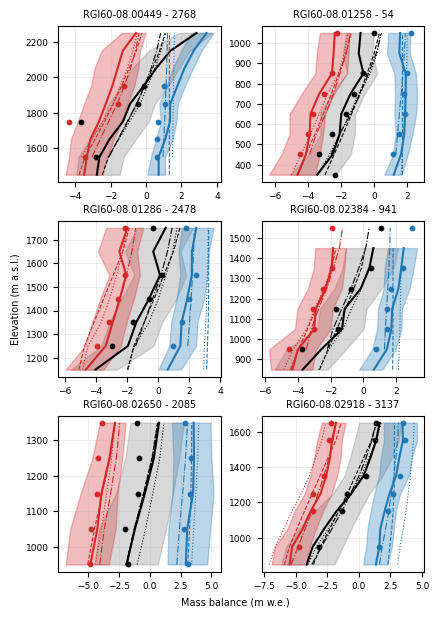

In [169]:
start_year = 1980
end_year = 2019

# Path to the folder containing the CSV files
folder_path = 'C:/Users/kasj/ML_MB_Norway/Data/glacier_predictions/with_predictions_2024-10-24_10-30-28/'

# List of test glaciers to include
# [north, north, west, west, west-mar, east]
test_glaciers = ['01258', '02384', '01286', '02918', '02650', '00449']
#test_glaciers = ['00434', '00449', '01013', '01026', '01258', '01286', '01484', '01598', '02384', '02650', '02916', '02918', '02920', '02969']

# Get a list of all CSV files in the folder
file_list = glob.glob(os.path.join(folder_path, '*.csv'))

# Filter the file_list to include only the files with the IDs in test_glaciers
filtered_file_list = [filename for filename in file_list if any(glacier_id in filename for glacier_id in test_glaciers)]

# Number of rows and columns for the subplots
nrows = 3
ncols = 2

cm=1/2.54
fontsize=7

# Create a figure with the specified number of subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12*cm, 18*cm))
axes = axes.flatten()

for idx, filename in enumerate(filtered_file_list):
    if idx >= nrows * ncols:
        break  # Stop if we have more files than subplots

    # Read each CSV file into a DataFrame
    df_pred = pd.read_csv(filename)
    df_pred = df_pred[(df_pred['year']>=start_year) & (df_pred['year']<=end_year)]
    
    # Ensure the DataFrame contains the necessary columns
    required_columns = ['altitude', 'Ba_pred', 'Bs_pred', 'Bw_pred', 'year']
    if not all(column in df_pred.columns for column in required_columns):
        print(f"Skipping {filename} as it does not contain the required columns.")
        continue

    # Step 1: Round the minimum and maximum altitude values to the nearest 100 meters
    min_altitude_rounded = np.floor(df_pred['altitude'].min() / 100) * 100
    max_altitude_rounded = np.ceil(df_pred['altitude'].max() / 100) * 100

    # Step 2: Create bins with 100-meter intervals
    bins = np.arange(min_altitude_rounded, max_altitude_rounded + 100, 100)

    # Step 3: Assign altitude intervals to the bins
    df_pred['altitude_interval'] = pd.cut(df_pred['altitude'], bins=bins, right=False)

    # Step 4: Name each interval by the mean (i.e., every whole 50 meters)
    bin_centers = {interval: round((interval.left + interval.right) / 2) for interval in df_pred['altitude_interval'].cat.categories}
    df_pred['altitude_interval'] = df_pred['altitude_interval'].apply(lambda x: bin_centers[x])

    # Step 5: Group by 'altitude_interval' and 'year' to calculate the mean values per year
    yearly_Ba_by_elevation = df_pred.groupby(['altitude_interval', 'year']).Ba_pred.mean().reset_index()
    yearly_Bs_by_elevation = df_pred.groupby(['altitude_interval', 'year']).Bs_pred.mean().reset_index()
    yearly_Bw_by_elevation = df_pred.groupby(['altitude_interval', 'year']).Bw_pred.mean().reset_index()

    # Step 6: Now calculate the mean, min, and max of these yearly means for each altitude interval
    agg_Ba_by_elevation = yearly_Ba_by_elevation.groupby('altitude_interval').agg(
        mean_Ba=('Ba_pred', 'mean'),
        min_Ba=('Ba_pred', 'min'),
        max_Ba=('Ba_pred', 'max')
    ).reset_index()

    agg_Bs_by_elevation = yearly_Bs_by_elevation.groupby('altitude_interval').agg(
        mean_Bs=('Bs_pred', 'mean'),
        min_Bs=('Bs_pred', 'min'),
        max_Bs=('Bs_pred', 'max')
    ).reset_index()

    agg_Bw_by_elevation = yearly_Bw_by_elevation.groupby('altitude_interval').agg(
        mean_Bw=('Bw_pred', 'mean'),
        min_Bw=('Bw_pred', 'min'),
        max_Bw=('Bw_pred', 'max')
    ).reset_index()

    # Get the subplot axis
    ax = axes[idx]

    # Step 7: Plotting
    # Plot shaded area and mean line for Ba_pred
    ax.fill_betweenx(agg_Ba_by_elevation['altitude_interval'],
                     agg_Ba_by_elevation['min_Ba'], agg_Ba_by_elevation['max_Ba'],
                     color='gray', alpha=0.3, label='Ba_pred Min-Max Range' if idx == 0 else "")
    ax.plot(agg_Ba_by_elevation['mean_Ba'], agg_Ba_by_elevation['altitude_interval'],
            label='Ba_pred Mean' if idx == 0 else "", color='k')

    # Plot shaded area and mean line for Bs_pred
    ax.fill_betweenx(agg_Bs_by_elevation['altitude_interval'],
                     agg_Bs_by_elevation['min_Bs'], agg_Bs_by_elevation['max_Bs'],
                     color='C3', alpha=0.3, label='Bs_pred Min-Max Range' if idx == 0 else "")
    ax.plot(agg_Bs_by_elevation['mean_Bs'], agg_Bs_by_elevation['altitude_interval'],
            label='Bs_pred Mean' if idx == 0 else "", color='C3')

    # Plot shaded area and mean line for Bw_pred
    ax.fill_betweenx(agg_Bw_by_elevation['altitude_interval'],
                     agg_Bw_by_elevation['min_Bw'], agg_Bw_by_elevation['max_Bw'],
                     color='C0', alpha=0.3, label='Bw_pred Min-Max Range' if idx == 0 else "")
    ax.plot(agg_Bw_by_elevation['mean_Bw'], agg_Bw_by_elevation['altitude_interval'],
            label='Bw_pred Mean' if idx == 0 else "", color='C0')

    glacier_id = df_pred['RGIID'].iloc[0][-4:]

    glacier_df_glogem = df_glogem_mean[df_glogem_mean['ID'] == glacier_id]
    glacier_df_oggm = df_oggm_mean[df_oggm_mean['ID'] == glacier_id]
    glacier_df_pygem = df_pygem_mean[df_pygem_mean['ID'] == glacier_id]

    # Plot the mean mass balance values
    # Diamond/dashdot for GloGEM
    # Square/dashed for OGGM
    # Circle/dotted for PyGEM
    alpha=1
    lw=0.8
    ax.plot(glacier_df_glogem['mb_annual'], glacier_df_glogem['elevation_bins'].astype(float), label='Annual Mass Balance', lw=lw, linestyle='-.',color='k', alpha=alpha)#marker='D', 
    ax.plot(glacier_df_glogem['mb_winter'], glacier_df_glogem['elevation_bins'].astype(float), label='Winter Mass Balance', lw=lw, linestyle='-.', color='C0',alpha=alpha)
    ax.plot(glacier_df_glogem['mb_summer'], glacier_df_glogem['elevation_bins'].astype(float), label='Summer Mass Balance', lw=lw, linestyle='-.', color='C3',alpha=alpha)
    ax.plot(glacier_df_oggm['mb_annual'], glacier_df_oggm['elevation_bins'].astype(float), label='Annual Mass Balance', lw=lw, linestyle='--', color='k',alpha=alpha)
    ax.plot(glacier_df_oggm['mb_winter'], glacier_df_oggm['elevation_bins'].astype(float), label='Winter Mass Balance', lw=lw, linestyle='--', color='C0',alpha=alpha)
    ax.plot(glacier_df_oggm['mb_summer'], glacier_df_oggm['elevation_bins'].astype(float), label='Summer Mass Balance', lw=lw, linestyle='--', color='C3',alpha=alpha)
    ax.plot(glacier_df_pygem['mb_annual'], glacier_df_pygem['elevation_bins'].astype(float), label='Annual Mass Balance', lw=lw, linestyle=':', color='k',alpha=alpha)
    ax.plot(glacier_df_pygem['mb_winter'], glacier_df_pygem['elevation_bins'].astype(float), label='Winter Mass Balance', lw=lw, linestyle=':', color='C0',alpha=alpha)
    ax.plot(glacier_df_pygem['mb_summer'], glacier_df_pygem['elevation_bins'].astype(float), label='Summer Mass Balance', lw=lw, linestyle=':', color='C3',alpha=alpha)
           
    glacier_name = df_pred['BREID'].iloc[0]

    # Add point mass balance observations
    glacier_obs = df_obs_mean[df_obs_mean['BREID']==glacier_name]
    ax.scatter(glacier_obs['balance_netto'], glacier_obs['elevation_bins'], marker='o', color='k', s=10)
    ax.scatter(glacier_obs['balance_winter'], glacier_obs['elevation_bins'], marker='o', color='C0', s=10)
    ax.scatter(glacier_obs['balance_summer'], glacier_obs['elevation_bins'], marker='o', color='C3', s=10)

    #ann_err = [glacier_obs['balance_netto'] - glacier_obs['min_annual'], glacier_obs['max_annual'] - glacier_obs['balance_netto']]
    #ax.errorbar(glacier_obs['balance_netto'], glacier_obs['elevation_bins'], xerr=ann_err, fmt='.', lw=2, capsize=3, alpha=0.7, zorder=0)
    
    #ax.axvline(x=0, color='grey', linestyle='--')
    
    #ax.set_title(f"RGI60-08.{os.path.basename(filename).split('_')[1].split('.')[0]}")
    ax.set_title(f"RGI60-08.{os.path.basename(filename).split('_')[1].split('.')[0]} - {glacier_name}", fontsize=fontsize)
    ax.grid(alpha=0.2)
    ax.tick_params(labelsize=6.5)
    ax.set_ylabel('')
    ax.set_xlabel('')

#axes[4].set_xlabel('Mass balance (m w.e.)', fontsize=fontsize)
#axes[5].set_xlabel('Mass balance (m w.e.)', fontsize=fontsize)

#axes[0].set_ylabel('Elevation (m)',fontsize=fontsize)
axes[2].set_ylabel('Elevation (m a.s.l.)',fontsize=fontsize)
#axes[4].set_ylabel('Elevation (m)',fontsize=fontsize)
fig.supxlabel('Mass balance (m w.e.)', fontsize=fontsize, y=0.06)
# Ensure legends show up
#handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper right')

# Adjust the layout
plt.subplots_adjust(hspace=0.25, wspace=0.25)
#plt.tight_layout(rect=[0, 0, 0.95, 0.97])

#pdf_path = 'C:/Users/kasj/OneDrive - Høgskulen på Vestlandet/Projects/2022_ML_for_MB_Norway/Figures_paper/'
#plt.savefig(pdf_path+'smb_gradients.pdf', format='pdf', bbox_inches='tight')

plt.show()
